# DINOV2 WITH AND WITHOUT REGISTERS

In [1]:
# Copyright (c) Facebook, Inc. and its affiliates.
# 
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
# 
#     http://www.apache.org/licenses/LICENSE-2.0
# 
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Note the original is here: https://github.com/facebookresearch/dino/blob/main/visualize_attention.py

import os
import sys
import argparse
import random
import colorsys
import requests
from io import BytesIO
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms as pth_transforms
import numpy as np
from PIL import Image
from dinov2.models.vision_transformer import vit_large
from dinov2.hub.backbones import dinov2_vitg14, dinov2_vitg14_reg
from dinov2.models.vision_transformer import DinoVisionTransformer
from torch.utils.data import DataLoader, Subset
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

/Users/alisiasarabaielli/Desktop/UVA/FACT/dinov2_loc/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/Users/alisiasarabaielli/Desktop/UVA/FACT/dinov2_loc/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/Users/alisiasarabaielli/Desktop/UVA/FACT/dinov2_loc/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


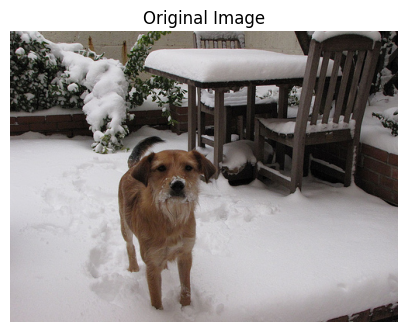

In [2]:
# input image
img = Image.open('dog.JPEG')
img = img.convert('RGB')


plt.figure(figsize=(5, 5))  
plt.imshow(img)  
plt.axis("off") 
plt.title("Original Image")  
plt.show()

## DINOV2 WITHOUT REG L

In [3]:
if __name__ == '__main__':
    image_size = (952, 952) 
    output_dir = '.'
    patch_size = 14

    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

    model = vit_large(
            patch_size=14,
            img_size=526,
            init_values=1.0,
            block_chunks=0
    )

    model.load_state_dict(torch.load('dinov2_vitl14_pretrain.pth'))
    for p in model.parameters():
        p.requires_grad = False
    model.to(device)
    model.eval()

    img = Image.open('dog.JPEG')
    img = img.convert('RGB')
    transform = pth_transforms.Compose([
        pth_transforms.Resize(image_size),
        pth_transforms.ToTensor(),
    ])
    img = transform(img)
    print(img.shape)

    w, h = img.shape[1] - img.shape[1] % patch_size, img.shape[2] - img.shape[2] % patch_size
    img = img[:, :w, :h].unsqueeze(0)

    w_featmap = img.shape[-2] // patch_size
    h_featmap = img.shape[-1] // patch_size

    print(img.shape)

    attentions = model.get_last_self_attention(img.to(device))
    
    nh = attentions.shape[1] # number of head

    # we keep only the output patch attention
    # for every patch
    #attentions = attentions[0, :, 0, 1:].reshape(nh, -1)
    
    attentions = attentions[0, :, 0, :] 

    # weird: one pixel gets high attention over all heads?
    #attentions[:, 283] = 0 

    attentions = attentions[:, 1:].reshape(nh, w_featmap, h_featmap)
    attentions = nn.functional.interpolate(attentions.unsqueeze(0), scale_factor=patch_size, mode="nearest")[0].cpu().numpy()


torch.Size([3, 952, 952])
torch.Size([1, 3, 952, 952])
Inside get_last_self_attention
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


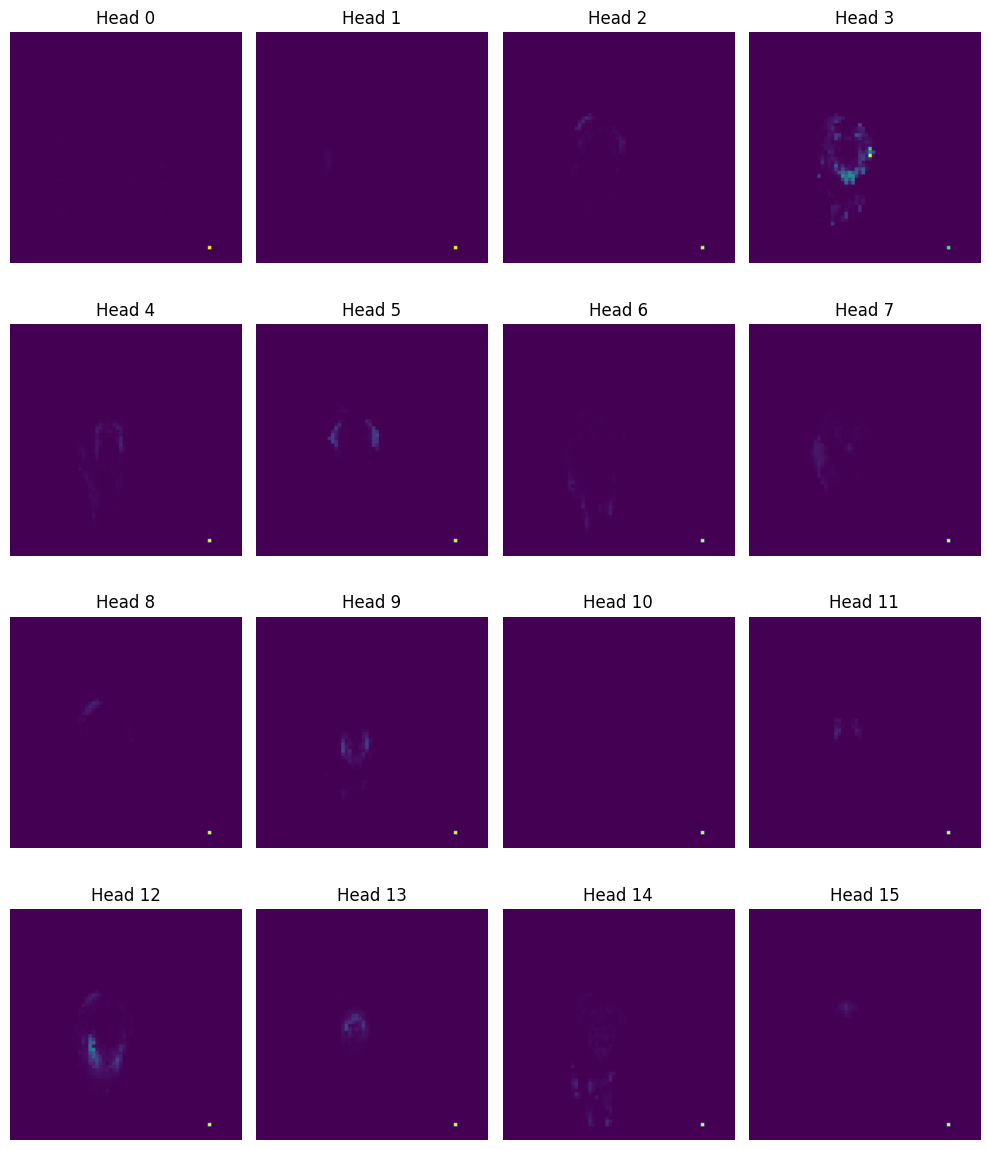

In [4]:

num_cols = 4  
num_rows = (nh + num_cols - 1) // num_cols 
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, num_rows * 3))

# Plot all attention maps
for j in range(nh):
    row, col = divmod(j, num_cols)  
    ax = axes[row, col]
    ax.imshow(attentions[j], cmap="viridis")
    ax.set_title(f"Head {j}")
    ax.axis("off")

for idx in range(nh, num_rows * num_cols):
    axes[idx // num_cols, idx % num_cols].axis("off")

plt.tight_layout()
plt.show()


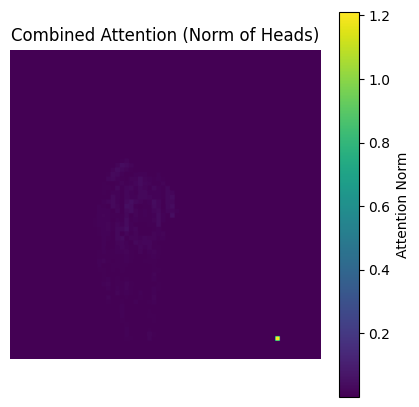

In [5]:
# DINOV2 HEAD NORM 

combined_attention = np.linalg.norm(attentions, axis=0) 

plt.figure(figsize=(5, 5))
plt.imshow(combined_attention, cmap="viridis")
plt.title("Combined Attention (Norm of Heads)")
plt.axis("off")
plt.colorbar(label="Attention Norm")
plt.show()


### Log-scale

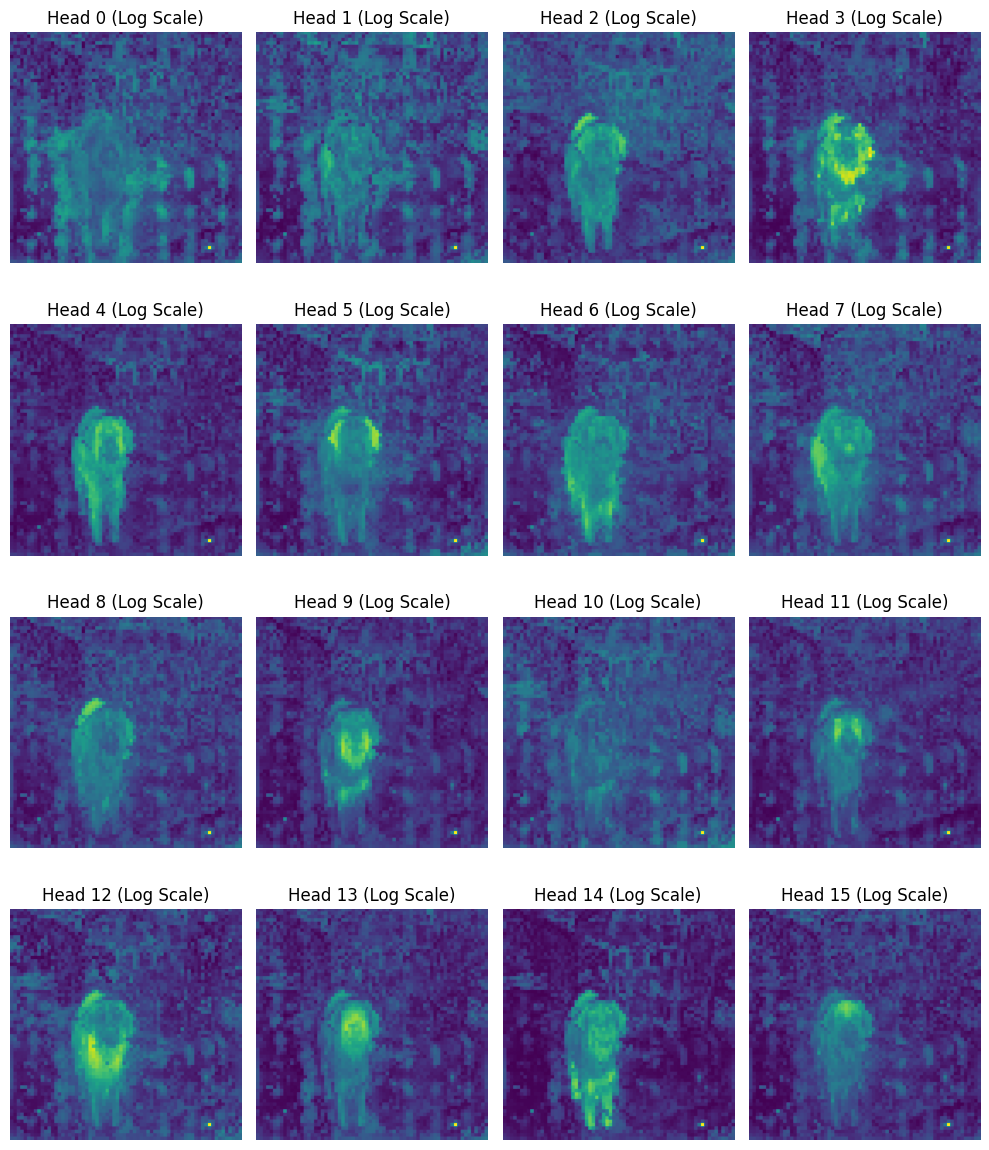

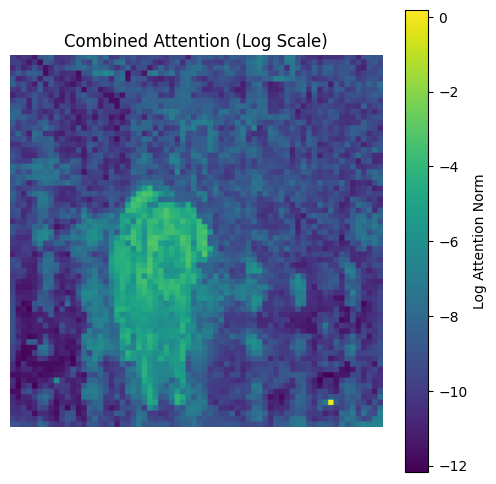

In [6]:
# log scale visualization 

epsilon = 1e-6  # small constant to prevent log(0)

log_attentions = np.log(attentions + epsilon)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, num_rows * 3))
for j in range(nh):
    row, col = divmod(j, num_cols)
    ax = axes[row, col]
    ax.imshow(log_attentions[j], cmap="viridis")
    ax.set_title(f"Head {j} (Log Scale)")
    ax.axis("off")

for idx in range(nh, num_rows * num_cols):
    axes[idx // num_cols, idx % num_cols].axis("off")

plt.tight_layout()
plt.show()

combined_attention_log = np.log(combined_attention + epsilon)

plt.figure(figsize=(6, 6))
plt.imshow(combined_attention_log, cmap="viridis")
plt.title("Combined Attention (Log Scale)")
plt.axis("off")
plt.colorbar(label="Log Attention Norm")
plt.show()


### Feature norms

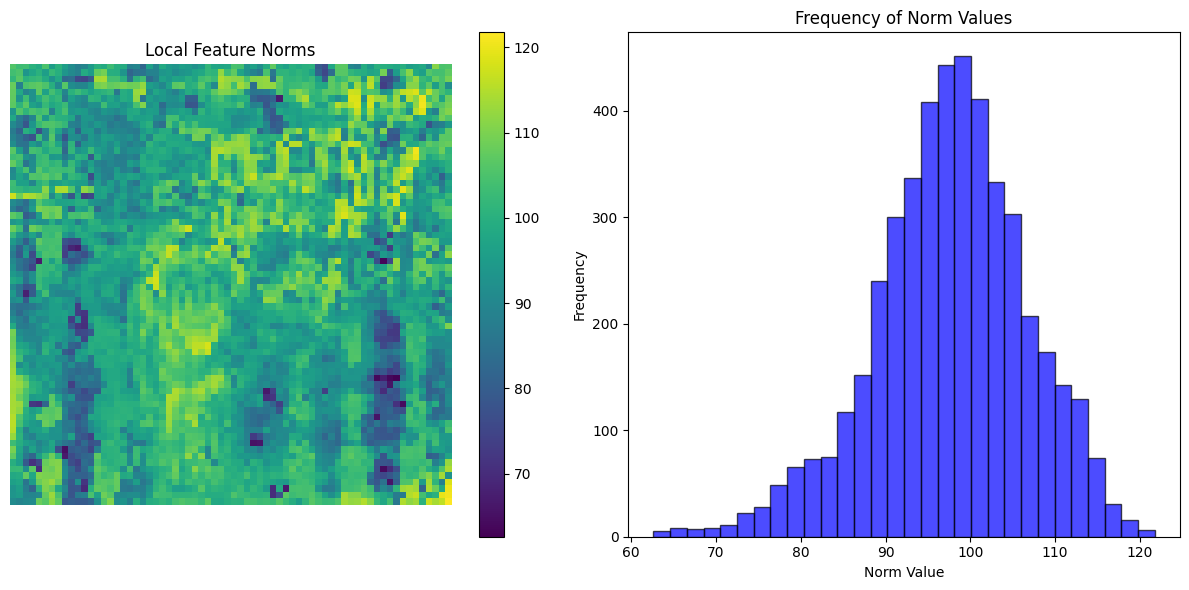

In [7]:
# DINOV2 NORMS WITHOUT REGISTERS

features = model.forward_features(img)["x_prenorm"]

patch_features = features[:, 1:, :]  
local_feature_norms = torch.norm(patch_features, dim=-1)  

w_featmap = img.shape[-2] // patch_size
h_featmap = img.shape[-1] // patch_size
local_feature_norms = local_feature_norms.reshape(-1, w_featmap, h_featmap)

flattened_norms = local_feature_norms[0].cpu().numpy().flatten()

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(local_feature_norms[0].cpu().numpy(), cmap="viridis")
plt.colorbar()
plt.title("Local Feature Norms")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.hist(flattened_norms, bins=30, color="blue", alpha=0.7, edgecolor="black")
plt.title("Frequency of Norm Values")
plt.xlabel("Norm Value")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


### Global attention check

Mean norm for high-attention patches: 105.83338165283203


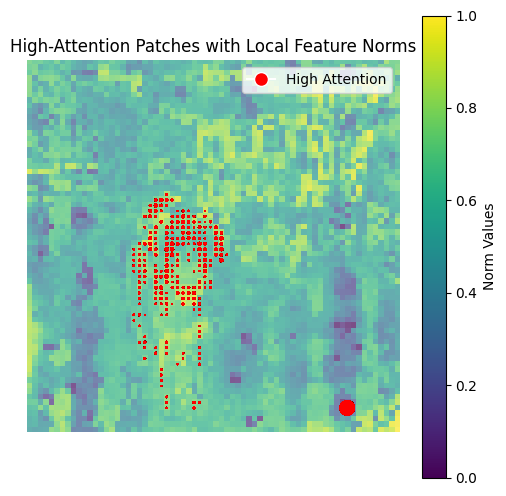

In [18]:
# check if high norms correspond to high values

high_attention_threshold = np.percentile(combined_attention, 95) 
high_attention_indices = np.where(combined_attention >= high_attention_threshold)

scale_factor = 196 // 14  
scaled_attention_indices = (high_attention_indices[0] // scale_factor, high_attention_indices[1] // scale_factor)

attention_values = combined_attention[high_attention_indices]

high_attention_norms = local_feature_norms[0].cpu().numpy()[scaled_attention_indices]

mean_high_attention_norm = np.mean(high_attention_norms)
print(f"Mean norm for high-attention patches: {mean_high_attention_norm}")

dot_sizes = (attention_values - np.min(attention_values)) / (np.max(attention_values) - np.min(attention_values)) * 100  

plt.figure(figsize=(6, 6))
plt.imshow(local_feature_norms[0].cpu().numpy(), cmap="viridis", alpha=0.7)
plt.scatter(scaled_attention_indices[1], scaled_attention_indices[0], color="red", s=dot_sizes)
plt.colorbar(label='Norm Values') 
plt.title("High-Attention Patches with Local Feature Norms")
plt.axis("off")
plt.legend(
    handles=[plt.Line2D([0], [0], marker='o', color='w', label='High Attention', 
                        markerfacecolor='red', markersize=10)], 
    loc='upper right', frameon=True, fontsize=10
)

plt.show()


In [2]:
# logistic regression norm-normal 
print("Loading CIFAR-10 dataset...")
transform = pth_transforms.Compose([
    pth_transforms.Resize((196, 196)),
    pth_transforms.ToTensor()
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_subset_size = 120
test_subset_size = 24
print(f"Creating subsets: {train_subset_size} training images, {test_subset_size} testing images...")
train_indices = torch.randperm(len(train_dataset))[:train_subset_size]
test_indices = torch.randperm(len(test_dataset))[:test_subset_size]
train_subset = Subset(train_dataset, train_indices)
test_subset = Subset(test_dataset, test_indices)

batch_size = 10
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)
print("Subsets and DataLoaders ready.")

print("Loading DINOv2 model...")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = vit_large(patch_size=14, img_size=526, init_values=1.0, block_chunks=0)
model.load_state_dict(torch.load('dinov2_vitl14_pretrain.pth'))  # Ensure this file is present
model.to(device)
model.eval()
print("DINOv2 model loaded and ready.")

Loading CIFAR-10 dataset...
Files already downloaded and verified
Files already downloaded and verified
Creating subsets: 120 training images, 24 testing images...
Subsets and DataLoaders ready.
Loading DINOv2 model...
DINOv2 model loaded and ready.


In [3]:
# Extract Patch Embeddings and Norms

high_norm_tokens = []
normal_tokens = []
labels_high = []  
labels_normal = [] 

print("Extracting patch embeddings...")
for batch_idx, (images, targets) in enumerate(train_loader):
    images = images.to(device)

    with torch.no_grad():
        features = model.forward_features(images)["x_prenorm"]
        patch_features = features[:, 1:, :]  
        norms = torch.norm(patch_features, dim=-1).cpu().numpy()

        for i in range(images.size(0)):  
            single_patch_features = patch_features[i]
            single_norms = norms[i]
            high_indices = np.where(single_norms > 100)[0]
            normal_indices = np.where(single_norms <= 100)[0]

            if high_indices.size > 0:
                high_norm_token = single_patch_features[high_indices[np.random.randint(len(high_indices))], :].cpu().numpy()
                high_norm_tokens.append(high_norm_token)
                labels_high.append(targets[i].item())

            if normal_indices.size > 0:
                normal_token = single_patch_features[normal_indices[np.random.randint(len(normal_indices))], :].cpu().numpy()
                normal_tokens.append(normal_token)
                labels_normal.append(targets[i].item())
    
    print(f"Processed batch {batch_idx + 1}/{len(train_loader)}")

print("Patch embedding extraction complete.")

print("Preparing datasets for Logistic Regression...")
X_high = np.array(high_norm_tokens)
X_normal = np.array(normal_tokens)
y_high = np.array(labels_high)
y_normal = np.array(labels_normal)

print(len(X_high), len(X_normal))
print(len(y_high), len(y_normal))

print("Splitting data into training and testing sets...")
X_high_train, X_high_test, y_high_train, y_high_test = train_test_split(X_high, y_high, test_size=0.2, random_state=42)
X_normal_train, X_normal_test, y_normal_train, y_normal_test = train_test_split(X_normal, y_normal, test_size=0.2, random_state=42)

Extracting patch embeddings...
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Processed batch 1/12
Processed batch 2/12
Processed batch 3/12
Processed batch 4/12
Processed batch 5/12
Processed batch 6/12
Processed batch 7/12
Processed batch 8/12
Processed batch 9/12
Processed batch 10/12
Processed batch 11/12
Processed batch 12/12
Patch embedding extraction complete.
Preparing datasets for Logistic Regression...
120 120
120 120
Splitting data into training and testing sets...


In [4]:
# Train Logistic Regression

print("Training Logistic Regression classifiers...")
clf_high = LogisticRegression(max_iter=1000).fit(X_high_train, y_high_train)
print("High-Norm Token classifier trained.")

clf_normal = LogisticRegression(max_iter=1000).fit(X_normal_train, y_normal_train)
print("Normal Token classifier trained.")

print("Evaluating classifiers...")
high_acc = accuracy_score(y_high_test, clf_high.predict(X_high_test))
normal_acc = accuracy_score(y_normal_test, clf_normal.predict(X_normal_test))

print(f"High-Norm Token Accuracy: {high_acc:.4f}")
print(f"Normal Token Accuracy: {normal_acc:.4f}")

Training Logistic Regression classifiers...
High-Norm Token classifier trained.
Normal Token classifier trained.
Evaluating classifiers...
High-Norm Token Accuracy: 0.7500
Normal Token Accuracy: 0.6250


## DINOV2 WITH REG L

In [3]:
if __name__ == '__main__':
    image_size = (952, 952)
    output_dir = '.'
    patch_size = 14

    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

    model_reg = vit_large(
        patch_size=14,
        img_size=526,
        init_values=1.0,
        block_chunks=0,
        num_register_tokens=4, 
    )

    state_dict = torch.load('dinov2_vitl14_reg4_pretrain.pth')
    model_reg.load_state_dict(state_dict, strict=True)

    for p in model_reg.parameters():
        p.requires_grad = False
    model_reg.to(device)
    model_reg.eval()

    # Process the input image
    img = Image.open('dog.JPEG')
    img = img.convert('RGB')
    transform = pth_transforms.Compose([
        pth_transforms.Resize(image_size),
        pth_transforms.ToTensor(),
    ])
    img = transform(img)
    w, h = img.shape[1] - img.shape[1] % patch_size, img.shape[2] - img.shape[2] % patch_size
    img = img[:, :w, :h].unsqueeze(0)

    w_featmap = img.shape[-2] // patch_size
    h_featmap = img.shape[-1] // patch_size
    print(f"Feature map size: {w_featmap} x {h_featmap}")

    attentions = model_reg.get_last_self_attention(img.to(device))
    nh = attentions.shape[1]  

    attentions = attentions[0, :, 0, :] 
    num_patches = w_featmap * h_featmap
    expected_tokens = 1 + 4 + num_patches 
    if attentions.size(1) != expected_tokens:
        raise RuntimeError(
            f"Token mismatch: expected {expected_tokens} tokens, but got {attentions.size(1)} tokens."
        )

    attentions = torch.cat([attentions[:, :1], attentions[:, 5:]], dim=1)  
    attentions = attentions[:, 1:].reshape(nh, w_featmap, h_featmap)

    attentions = nn.functional.interpolate(
        attentions.unsqueeze(0), scale_factor=patch_size, mode="nearest"
    )[0].cpu().numpy()

Feature map size: 68 x 68
Inside get_last_self_attention
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


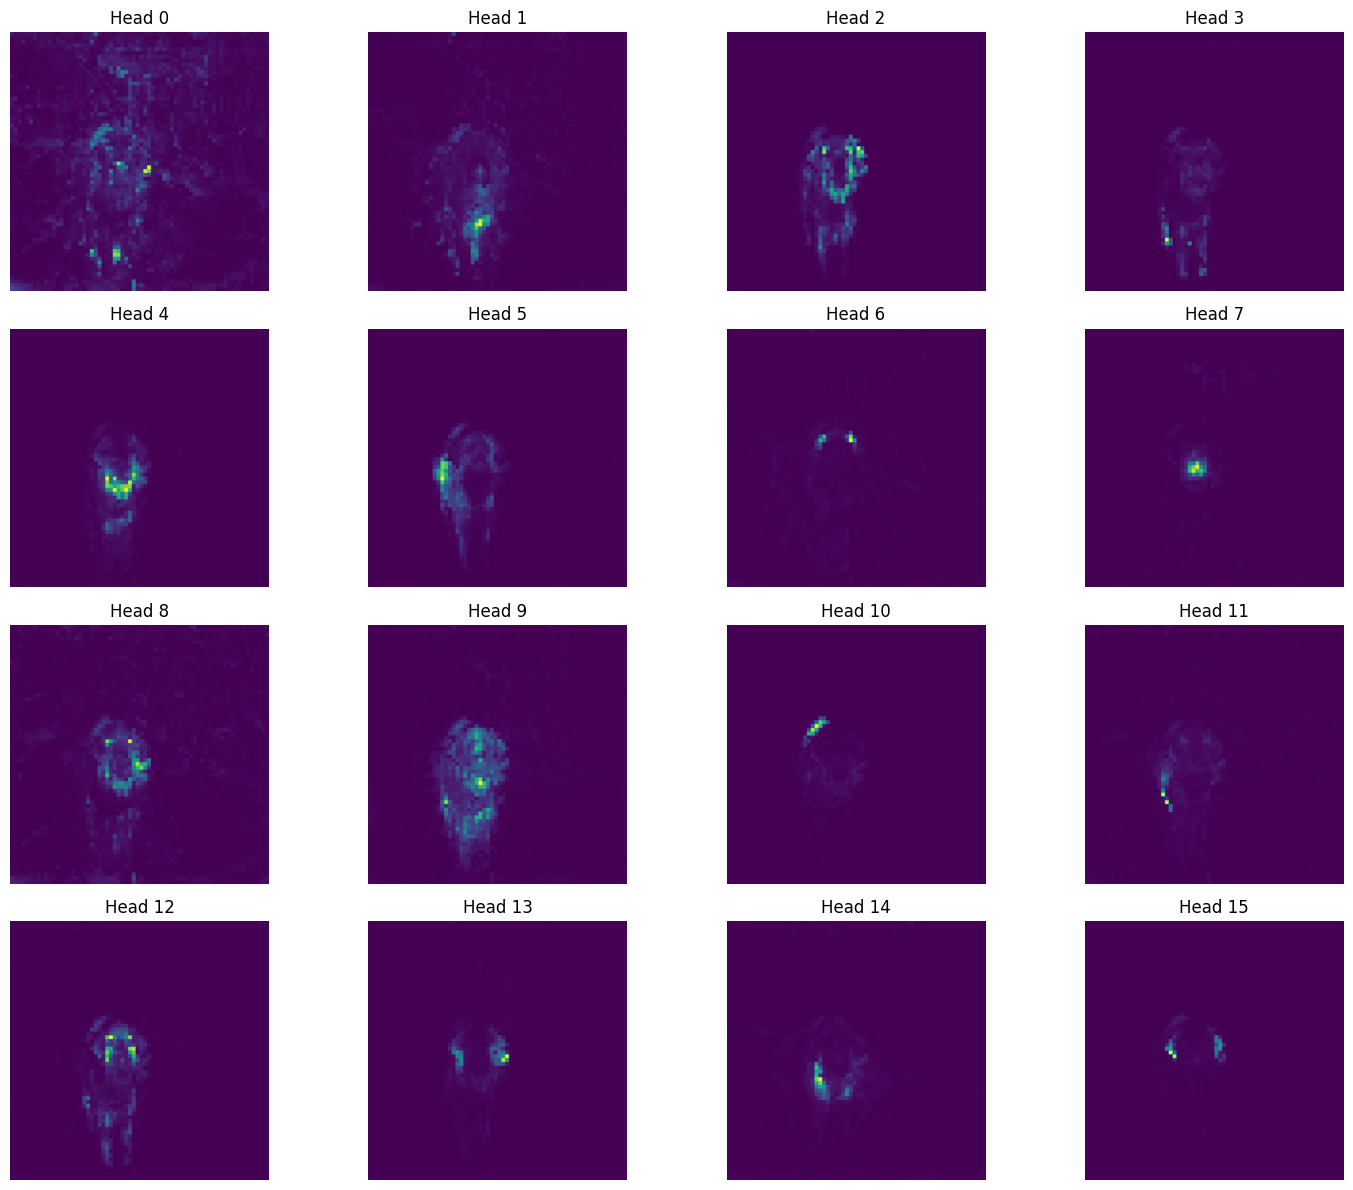

In [4]:

num_cols = 4  
num_rows = (nh + num_cols - 1) // num_cols 
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 3))

for j in range(nh):
    row, col = divmod(j, num_cols)  
    ax = axes[row, col]
    ax.imshow(attentions[j], cmap="viridis")
    ax.set_title(f"Head {j}")
    ax.axis("off")

for idx in range(nh, num_rows * num_cols):
    axes[idx // num_cols, idx % num_cols].axis("off")

plt.tight_layout()
plt.show()


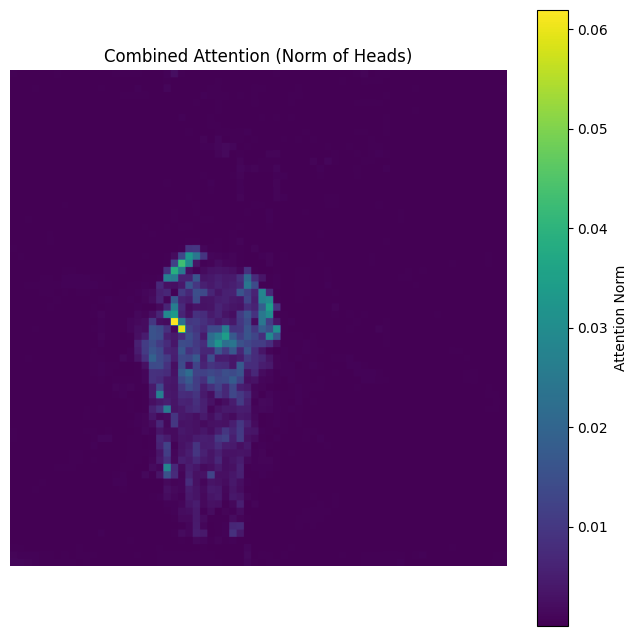

In [5]:
# DINOV2 HEAD NORM 

combined_attention = np.linalg.norm(attentions, axis=0) 

plt.figure(figsize=(8, 8))
plt.imshow(combined_attention, cmap="viridis")
plt.title("Combined Attention (Norm of Heads)")
plt.axis("off")
plt.colorbar(label="Attention Norm")
plt.show()

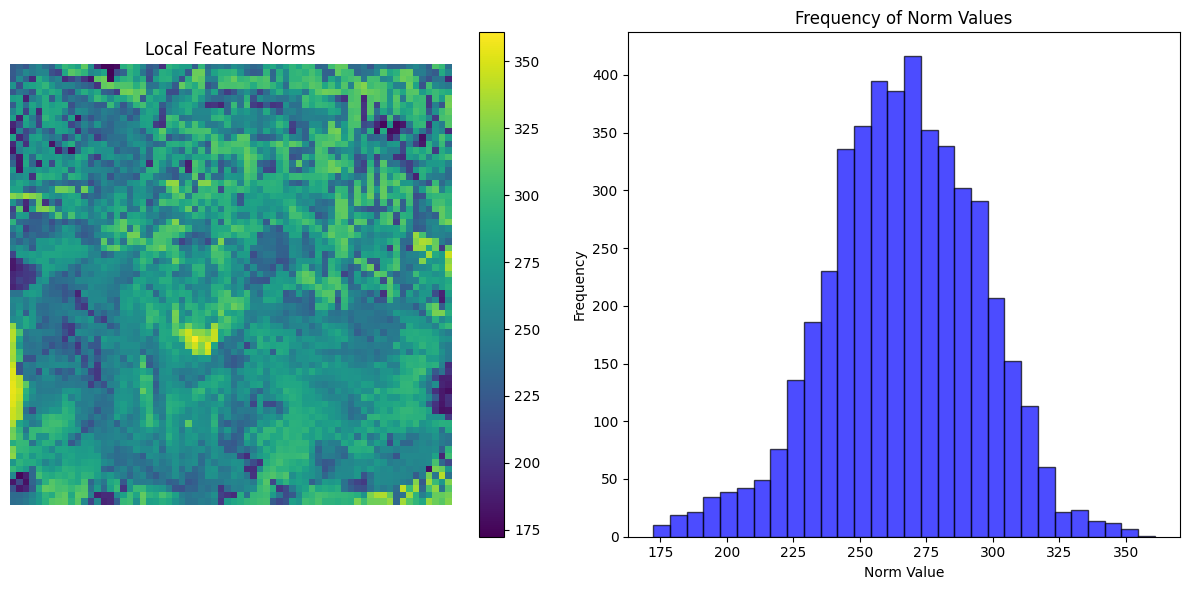

In [11]:
# DINOV2 NORMS WITH REGISTERS

features = model_reg.forward_features(img)["x_prenorm"]
patch_features = features[:, 1 + 4:, :]
local_feature_norms = torch.norm(patch_features, dim=-1) 
w_featmap = img.shape[-2] // patch_size
h_featmap = img.shape[-1] // patch_size


num_patches = patch_features.shape[1]
local_feature_norms = local_feature_norms.reshape(-1, w_featmap, h_featmap)

flattened_norms = local_feature_norms[0].cpu().numpy().flatten()
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(local_feature_norms[0].cpu().numpy(), cmap="viridis")
plt.colorbar()
plt.title("Local Feature Norms")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.hist(flattened_norms, bins=30, color="blue", alpha=0.7, edgecolor="black")
plt.title("Frequency of Norm Values")
plt.xlabel("Norm Value")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


## DINOV2 WITHOUT REG G

In [3]:
if __name__ == '__main__':
    image_size = (952, 952) 
    output_dir = '.'
    patch_size = 14

    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

    model = dinov2_vitg14(
            patch_size=14,
            img_size=526,
            init_values=1.0,
            block_chunks=0
    )

    model.load_state_dict(torch.load('dinov2_vitg14_pretrain.pth'))
    for p in model.parameters():
        p.requires_grad = False
    model.to(device)
    model.eval()

    img = Image.open('dog.JPEG')
    img = img.convert('RGB')
    transform = pth_transforms.Compose([
        pth_transforms.Resize(image_size),
        pth_transforms.ToTensor(),
    ])
    img = transform(img)
    print(img.shape)

    w, h = img.shape[1] - img.shape[1] % patch_size, img.shape[2] - img.shape[2] % patch_size
    img = img[:, :w, :h].unsqueeze(0)

    w_featmap = img.shape[-2] // patch_size
    h_featmap = img.shape[-1] // patch_size

    print(img.shape)

    attentions = model.get_last_self_attention(img.to(device))
    
    nh = attentions.shape[1] # number of head

    # we keep only the output patch attention
    # for every patch
    #attentions = attentions[0, :, 0, 1:].reshape(nh, -1)
    
    attentions = attentions[0, :, 0, :] 

    # weird: one pixel gets high attention over all heads?
    #attentions[:, 283] = 0 

    attentions = attentions[:, 1:].reshape(nh, w_featmap, h_featmap)
    attentions = nn.functional.interpolate(attentions.unsqueeze(0), scale_factor=patch_size, mode="nearest")[0].cpu().numpy()


torch.Size([3, 952, 952])
torch.Size([1, 3, 952, 952])
Inside get_last_self_attention
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


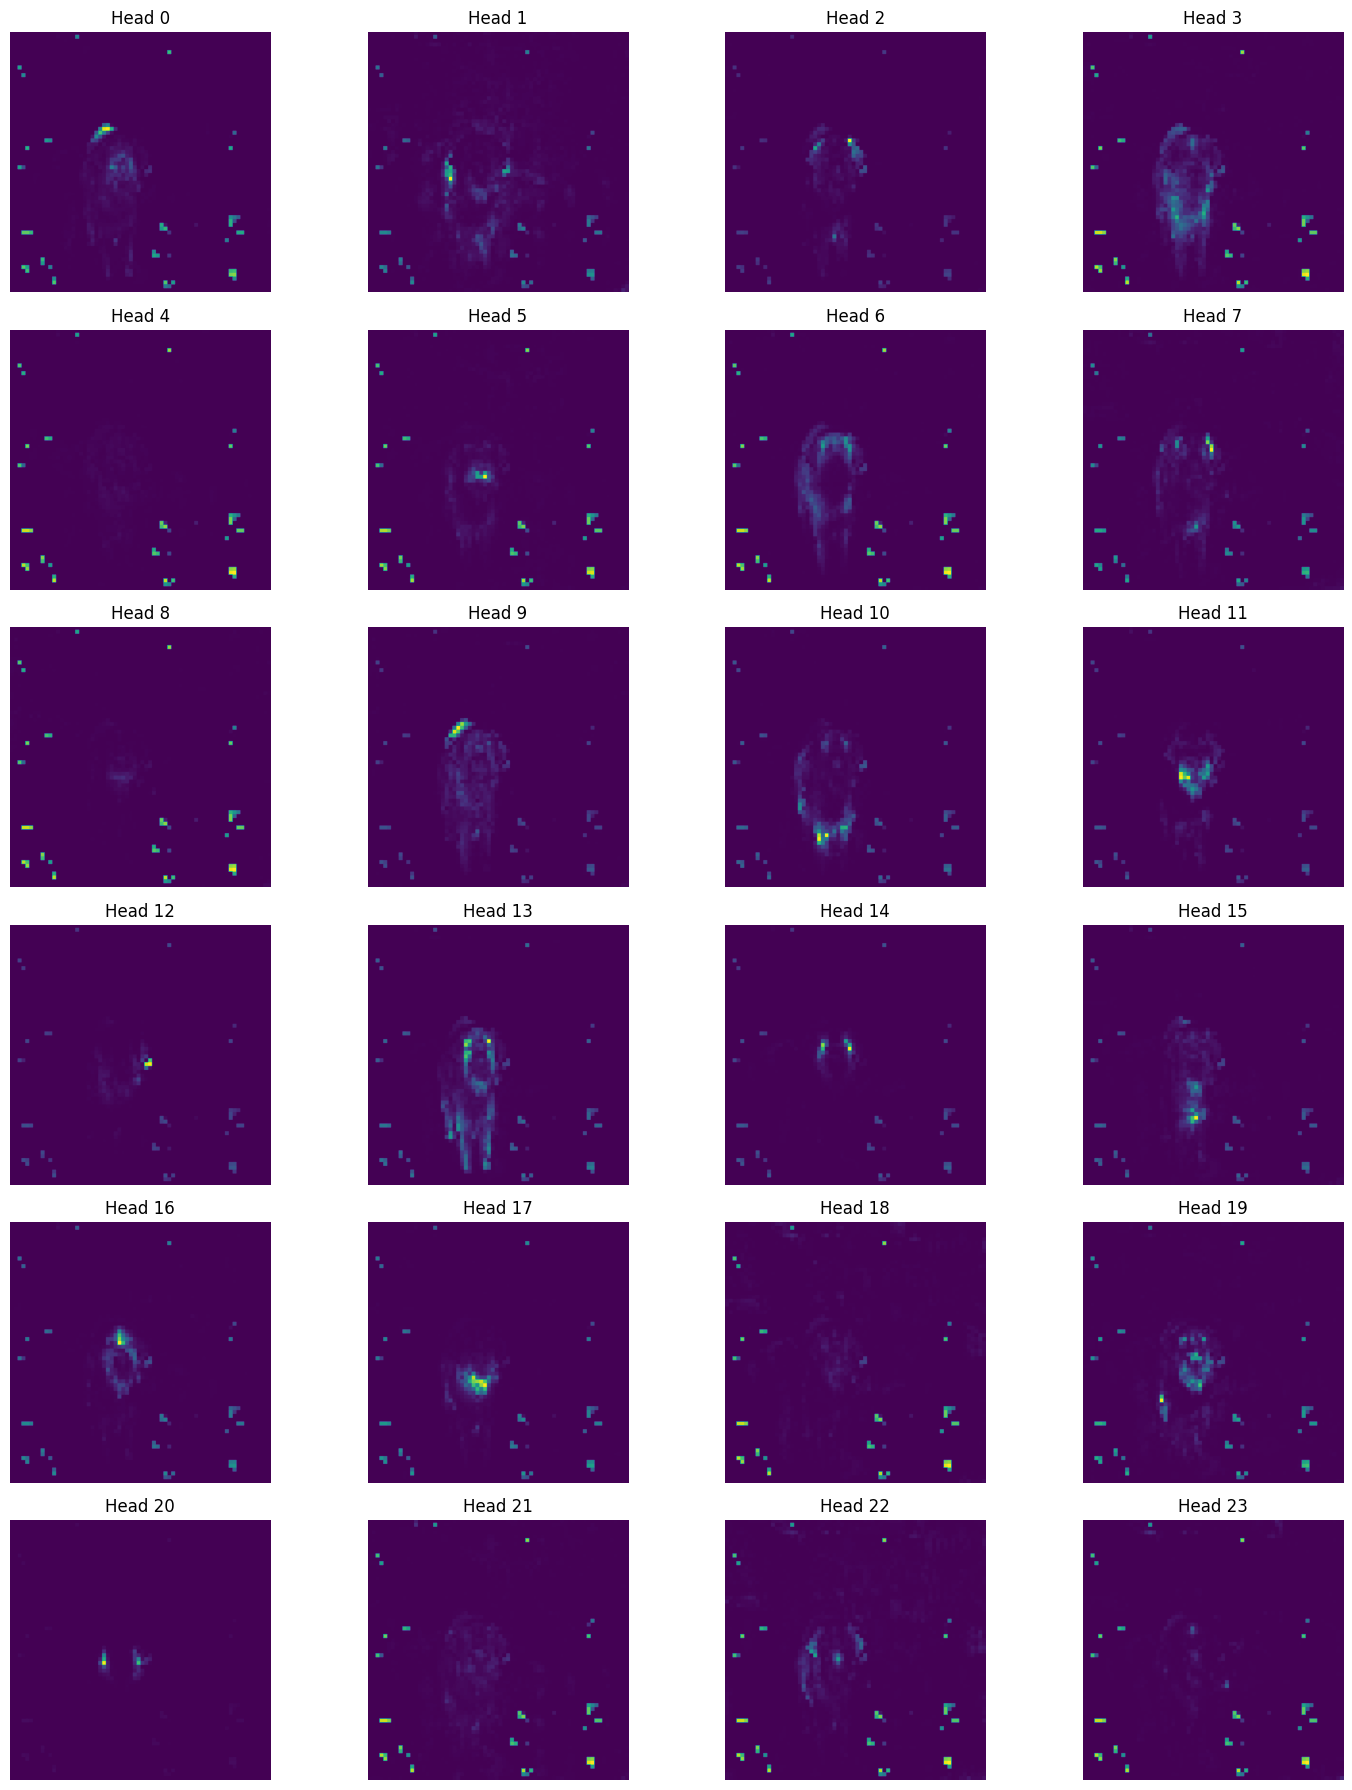

In [4]:

num_cols = 4  
num_rows = (nh + num_cols - 1) // num_cols 
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 3))

# Plot all attention maps
for j in range(nh):
    row, col = divmod(j, num_cols)  
    ax = axes[row, col]
    ax.imshow(attentions[j], cmap="viridis")
    ax.set_title(f"Head {j}")
    ax.axis("off")

for idx in range(nh, num_rows * num_cols):
    axes[idx // num_cols, idx % num_cols].axis("off")

plt.tight_layout()
plt.show()

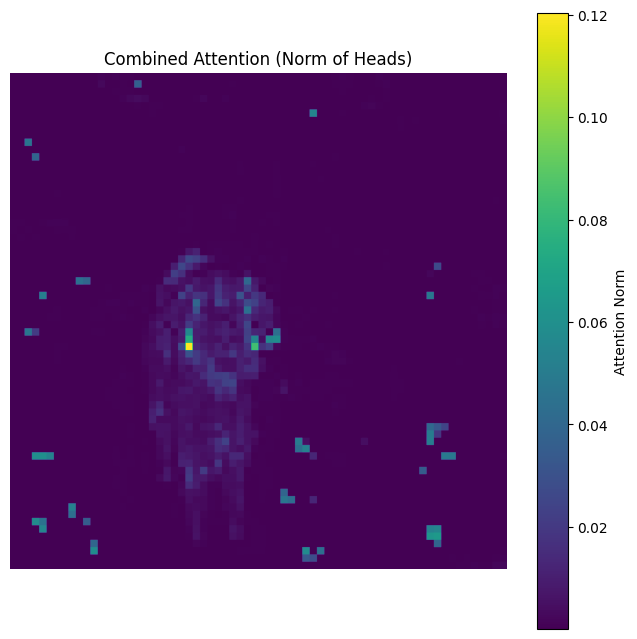

In [5]:
# DINOV2 HEAD NORM 

combined_attention = np.linalg.norm(attentions, axis=0) 

plt.figure(figsize=(8, 8))
plt.imshow(combined_attention, cmap="viridis")
plt.title("Combined Attention (Norm of Heads)")
plt.axis("off")
plt.colorbar(label="Attention Norm")
plt.show()


### Feature norms

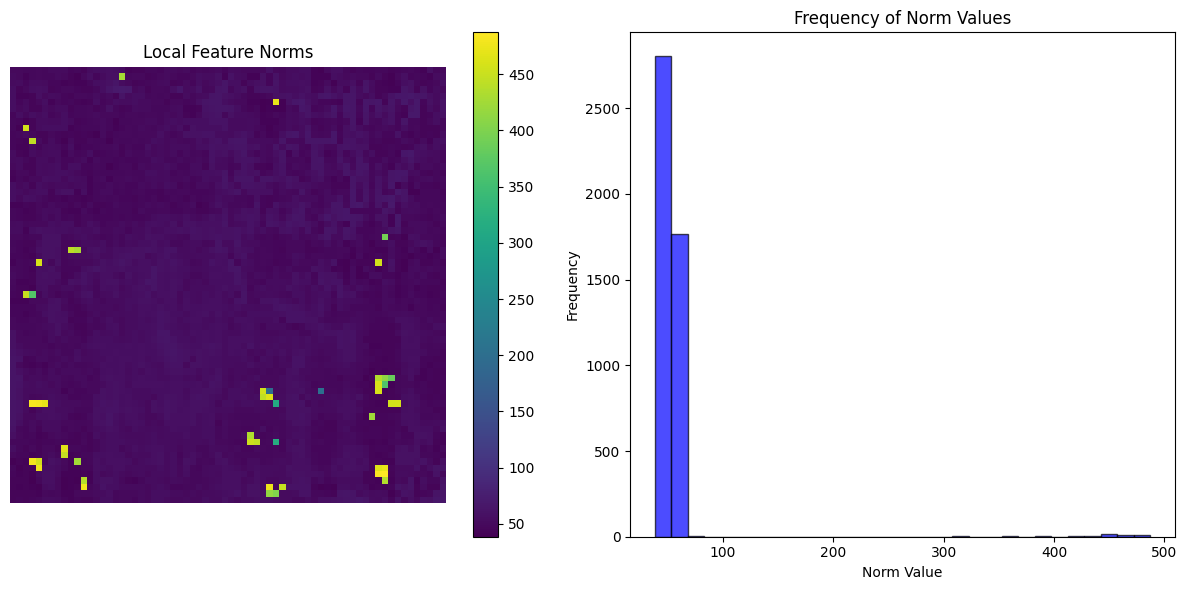

In [6]:
# DINOV2 NORMS WITHOUT REGISTERS

features = model.forward_features(img)["x_prenorm"]

patch_features = features[:, 1:, :]  
local_feature_norms = torch.norm(patch_features, dim=-1)  

w_featmap = img.shape[-2] // patch_size
h_featmap = img.shape[-1] // patch_size
local_feature_norms = local_feature_norms.reshape(-1, w_featmap, h_featmap)

flattened_norms = local_feature_norms[0].cpu().numpy().flatten()

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(local_feature_norms[0].cpu().numpy(), cmap="viridis")
plt.colorbar()
plt.title("Local Feature Norms")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.hist(flattened_norms, bins=30, color="blue", alpha=0.7, edgecolor="black")
plt.title("Frequency of Norm Values")
plt.xlabel("Norm Value")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

### Log-scale

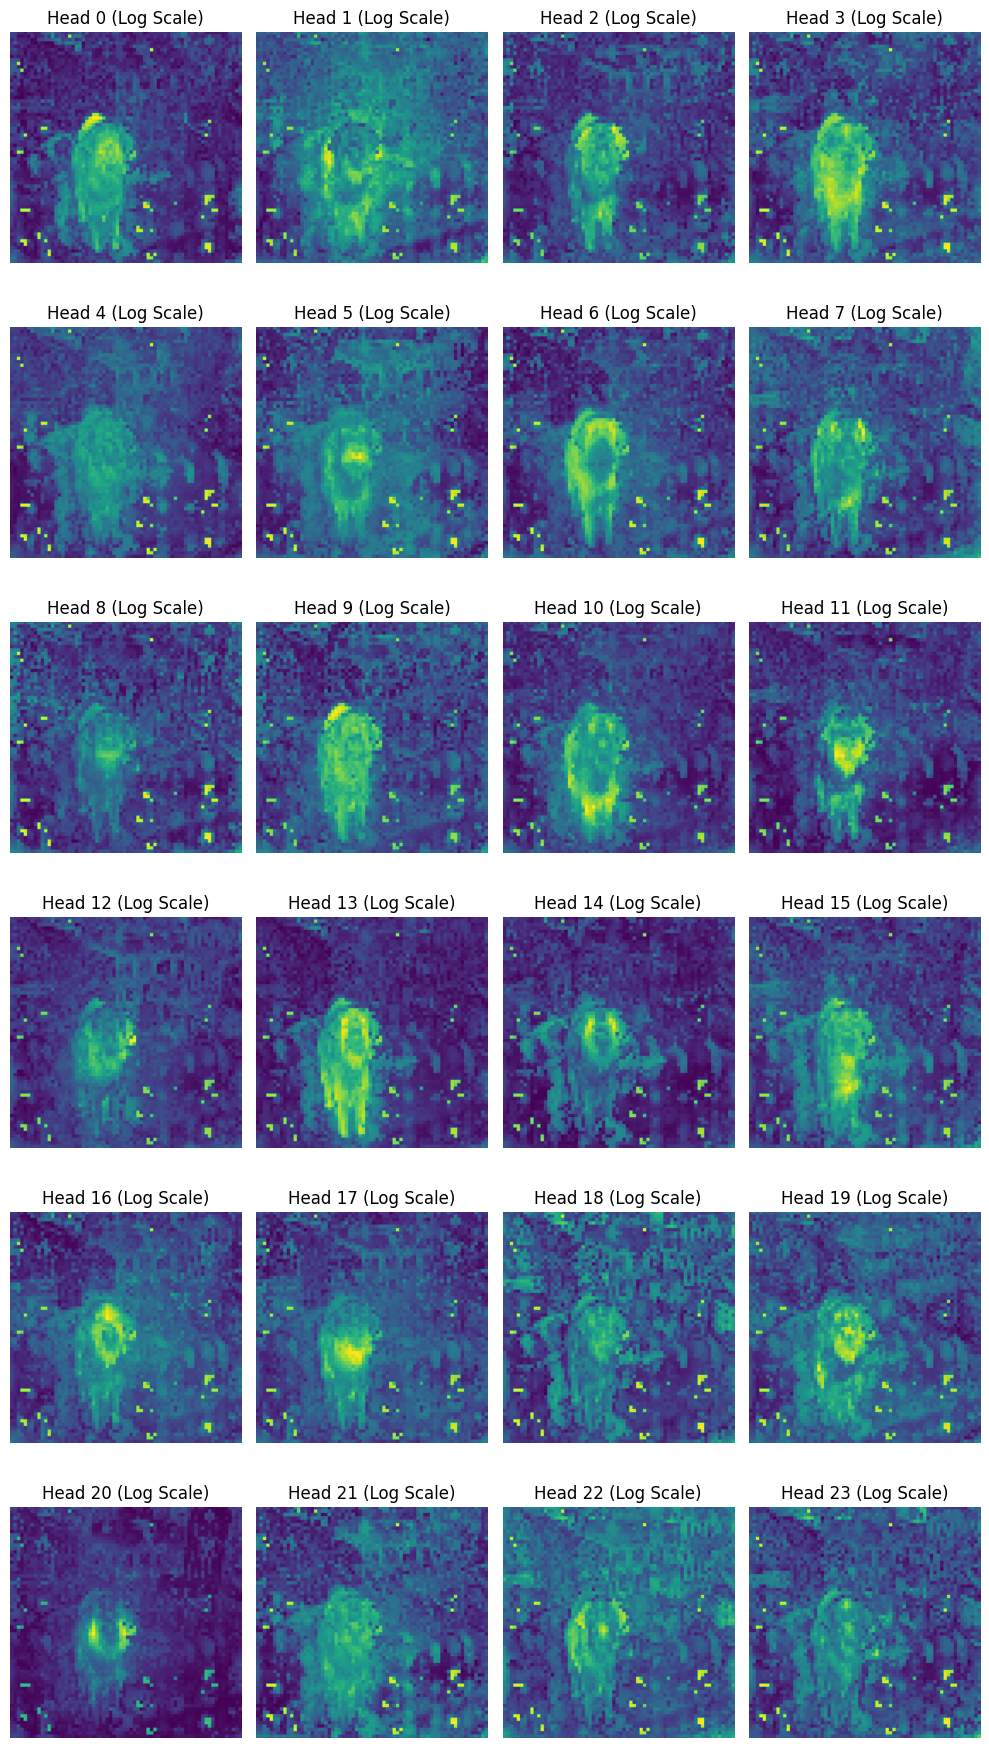

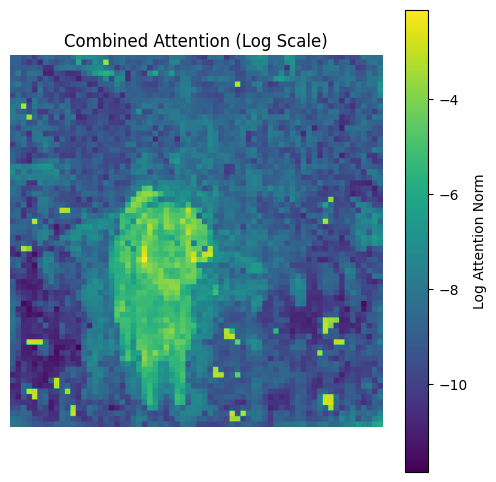

In [7]:
# log scale visualization 

epsilon = 1e-6  # small constant to prevent log(0)

log_attentions = np.log(attentions + epsilon)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, num_rows * 3))
for j in range(nh):
    row, col = divmod(j, num_cols)
    ax = axes[row, col]
    ax.imshow(log_attentions[j], cmap="viridis")
    ax.set_title(f"Head {j} (Log Scale)")
    ax.axis("off")

for idx in range(nh, num_rows * num_cols):
    axes[idx // num_cols, idx % num_cols].axis("off")

plt.tight_layout()
plt.show()

combined_attention_log = np.log(combined_attention + epsilon)

plt.figure(figsize=(6, 6))
plt.imshow(combined_attention_log, cmap="viridis")
plt.title("Combined Attention (Log Scale)")
plt.axis("off")
plt.colorbar(label="Log Attention Norm")
plt.show()

### Global attention check

Mean norm for high-attention patches: 189.27195739746094


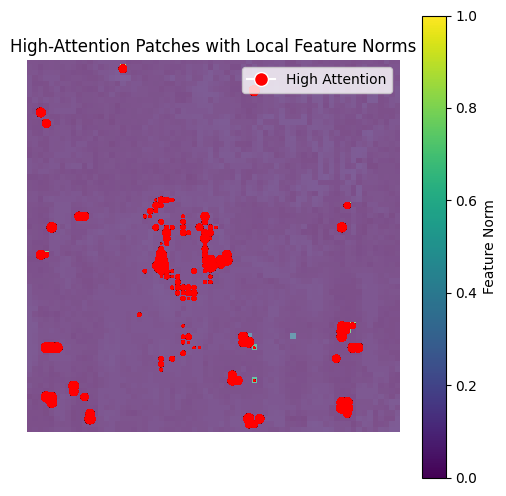

In [13]:
# check if high norms correspond to high values

high_attention_threshold = np.percentile(combined_attention, 97) 
high_attention_indices = np.where(combined_attention >= high_attention_threshold)

scale_factor = 196 // 14  
scaled_attention_indices = (high_attention_indices[0] // scale_factor, high_attention_indices[1] // scale_factor)

attention_values = combined_attention[high_attention_indices]

high_attention_norms = local_feature_norms[0].cpu().numpy()[scaled_attention_indices]

mean_high_attention_norm = np.mean(high_attention_norms)
print(f"Mean norm for high-attention patches: {mean_high_attention_norm}")

dot_sizes = (attention_values - np.min(attention_values)) / (np.max(attention_values) - np.min(attention_values)) * 100  
plt.figure(figsize=(6, 6))
plt.imshow(local_feature_norms[0].cpu().numpy(), cmap="viridis", alpha=0.7)
plt.scatter(scaled_attention_indices[1], scaled_attention_indices[0], color="red", s=dot_sizes)
plt.title("High-Attention Patches with Local Feature Norms")
plt.axis("off")
plt.colorbar(label="Feature Norm")
plt.legend(
    handles=[plt.Line2D([0], [0], marker='o', color='w', label='High Attention', 
                        markerfacecolor='red', markersize=10)], 
    loc='upper right', frameon=True, fontsize=10
)

plt.show()

In [14]:
# logistic regression norm-normal 
print("Loading CIFAR-10 dataset...")
transform = pth_transforms.Compose([
    pth_transforms.Resize((196, 196)),
    pth_transforms.ToTensor()
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_subset_size = 100
test_subset_size = 40
print(f"Creating subsets: {train_subset_size} training images, {test_subset_size} testing images...")
train_indices = torch.randperm(len(train_dataset))[:train_subset_size]
test_indices = torch.randperm(len(test_dataset))[:test_subset_size]
train_subset = Subset(train_dataset, train_indices)
test_subset = Subset(test_dataset, test_indices)

batch_size = 10
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)
print("Subsets and DataLoaders ready.")

print("Loading DINOv2 model...")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = vit_large(patch_size=14, img_size=526, init_values=1.0, block_chunks=0)
model.load_state_dict(torch.load('dinov2_vitl14_pretrain.pth'))  # Ensure this file is present
model.to(device)
model.eval()
print("DINOv2 model loaded and ready.")

Loading CIFAR-10 dataset...
Files already downloaded and verified
Files already downloaded and verified
Creating subsets: 100 training images, 40 testing images...
Subsets and DataLoaders ready.
Loading DINOv2 model...
DINOv2 model loaded and ready.


In [15]:
# Extract Patch Embeddings and Norms

high_norm_tokens = []
normal_tokens = []
labels_high = []  
labels_normal = [] 

print("Extracting patch embeddings...")
for batch_idx, (images, targets) in enumerate(train_loader):
    images = images.to(device)

    with torch.no_grad():
        features = model.forward_features(images)["x_prenorm"]
        patch_features = features[:, 1:, :]  
        norms = torch.norm(patch_features, dim=-1).cpu().numpy()

        for i in range(images.size(0)):  
            single_patch_features = patch_features[i]
            single_norms = norms[i]
            high_indices = np.where(single_norms > 100)[0]
            normal_indices = np.where(single_norms <= 100)[0]

            if high_indices.size > 0:
                high_norm_token = single_patch_features[high_indices[np.random.randint(len(high_indices))], :].cpu().numpy()
                high_norm_tokens.append(high_norm_token)
                labels_high.append(targets[i].item())

            if normal_indices.size > 0:
                normal_token = single_patch_features[normal_indices[np.random.randint(len(normal_indices))], :].cpu().numpy()
                normal_tokens.append(normal_token)
                labels_normal.append(targets[i].item())
    
    print(f"Processed batch {batch_idx + 1}/{len(train_loader)}")

print("Patch embedding extraction complete.")

print("Preparing datasets for Logistic Regression...")
X_high = np.array(high_norm_tokens)
X_normal = np.array(normal_tokens)
y_high = np.array(labels_high)
y_normal = np.array(labels_normal)

print(len(X_high), len(X_normal))
print(len(y_high), len(y_normal))

print("Splitting data into training and testing sets...")
X_high_train, X_high_test, y_high_train, y_high_test = train_test_split(X_high, y_high, test_size=0.2, random_state=42)
X_normal_train, X_normal_test, y_normal_train, y_normal_test = train_test_split(X_normal, y_normal, test_size=0.2, random_state=42)

Extracting patch embeddings...
Processed batch 1/10
Processed batch 2/10
Processed batch 3/10
Processed batch 4/10
Processed batch 5/10
Processed batch 6/10
Processed batch 7/10
Processed batch 8/10
Processed batch 9/10
Processed batch 10/10
Patch embedding extraction complete.
Preparing datasets for Logistic Regression...
100 100
100 100
Splitting data into training and testing sets...


In [16]:
# Train Logistic Regression

print("Training Logistic Regression classifiers...")
clf_high = LogisticRegression(max_iter=1000).fit(X_high_train, y_high_train)
print("High-Norm Token classifier trained.")

clf_normal = LogisticRegression(max_iter=1000).fit(X_normal_train, y_normal_train)
print("Normal Token classifier trained.")

print("Evaluating classifiers...")
high_acc = accuracy_score(y_high_test, clf_high.predict(X_high_test))
normal_acc = accuracy_score(y_normal_test, clf_normal.predict(X_normal_test))

print(f"High-Norm Token Accuracy: {high_acc:.4f}")
print(f"Normal Token Accuracy: {normal_acc:.4f}")

Training Logistic Regression classifiers...
High-Norm Token classifier trained.
Normal Token classifier trained.
Evaluating classifiers...
High-Norm Token Accuracy: 0.8500
Normal Token Accuracy: 0.8000


## DINOV2 WITH REG G

In [2]:
if __name__ == '__main__':
    image_size = (952, 952)
    output_dir = '.'
    patch_size = 14

    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

    model_reg = dinov2_vitg14_reg(
        patch_size=14,
        img_size=526,
        init_values=1.0,
        block_chunks=0#,
       # num_register_tokens=4, 
    )

    state_dict = torch.load('dinov2_vitg14_reg4_pretrain.pth')
    model_reg.load_state_dict(state_dict, strict=True)

    for p in model_reg.parameters():
        p.requires_grad = False
    model_reg.to(device)
    model_reg.eval()

    img = Image.open('dog.JPEG')
    img = img.convert('RGB')
    transform = pth_transforms.Compose([
        pth_transforms.Resize(image_size),
        pth_transforms.ToTensor(),
    ])
    img = transform(img)
    w, h = img.shape[1] - img.shape[1] % patch_size, img.shape[2] - img.shape[2] % patch_size
    img = img[:, :w, :h].unsqueeze(0)

    w_featmap = img.shape[-2] // patch_size
    h_featmap = img.shape[-1] // patch_size
    print(f"Feature map size: {w_featmap} x {h_featmap}")

    attentions = model_reg.get_last_self_attention(img.to(device))
    nh = attentions.shape[1]  

    attentions = attentions[0, :, 0, :] 
    num_patches = w_featmap * h_featmap
    expected_tokens = 1 + 4 + num_patches 
    if attentions.size(1) != expected_tokens:
        raise RuntimeError(
            f"Token mismatch: expected {expected_tokens} tokens, but got {attentions.size(1)} tokens."
        )

    attentions = torch.cat([attentions[:, :1], attentions[:, 5:]], dim=1)  
    attentions = attentions[:, 1:].reshape(nh, w_featmap, h_featmap)

    attentions = nn.functional.interpolate(
        attentions.unsqueeze(0), scale_factor=patch_size, mode="nearest"
    )[0].cpu().numpy()

Feature map size: 68 x 68
Inside get_last_self_attention
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


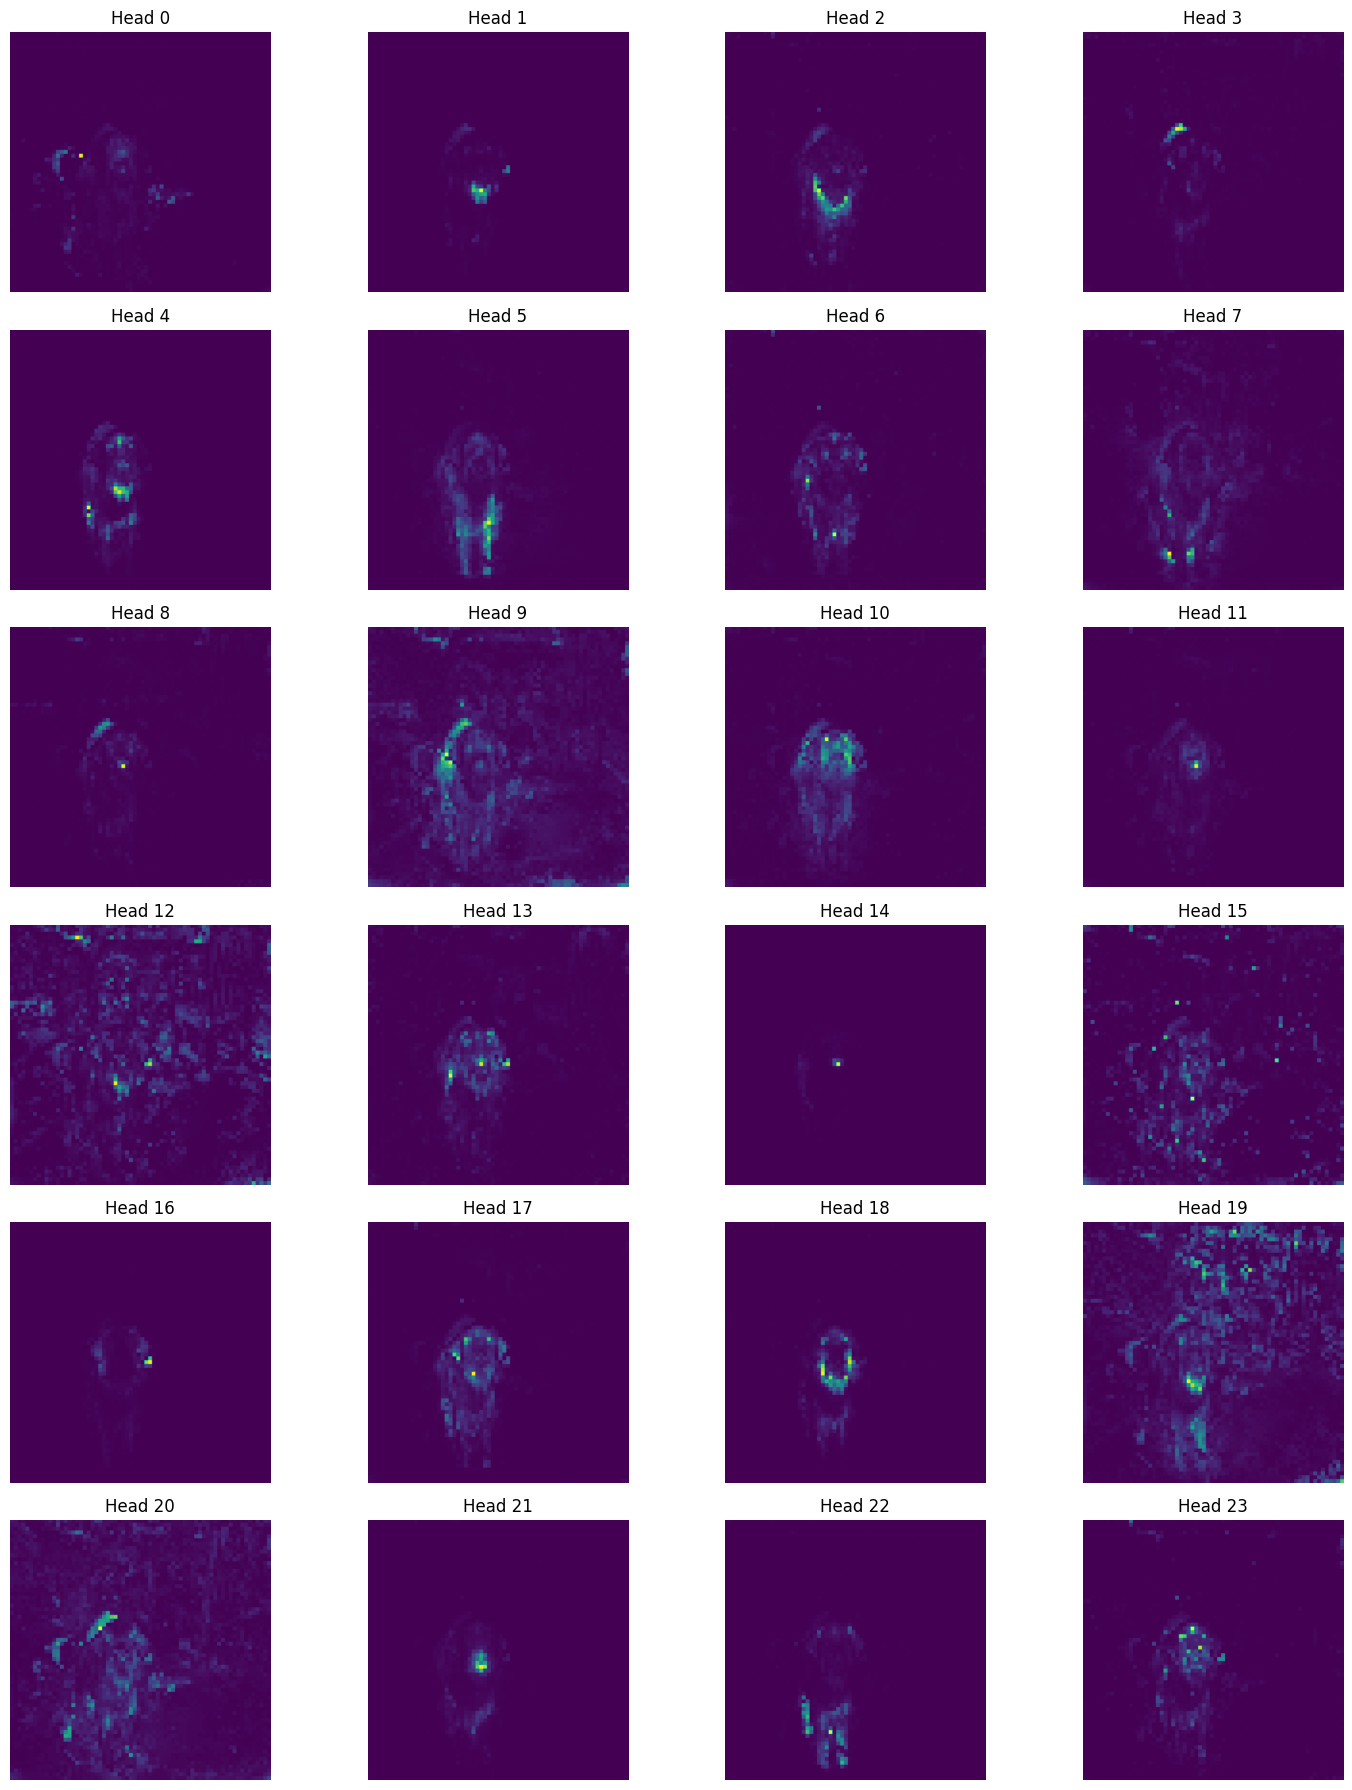

In [3]:

num_cols = 4  
num_rows = (nh + num_cols - 1) // num_cols 
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 3))

for j in range(nh):
    row, col = divmod(j, num_cols)  
    ax = axes[row, col]
    ax.imshow(attentions[j], cmap="viridis")
    ax.set_title(f"Head {j}")
    ax.axis("off")

for idx in range(nh, num_rows * num_cols):
    axes[idx // num_cols, idx % num_cols].axis("off")

plt.tight_layout()
plt.show()


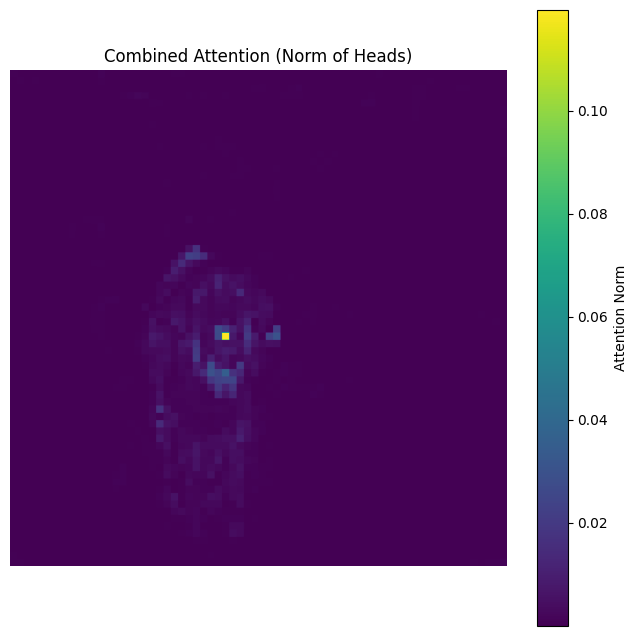

In [4]:
# DINOV2 HEAD NORM 

combined_attention = np.linalg.norm(attentions, axis=0) 

plt.figure(figsize=(8, 8))
plt.imshow(combined_attention, cmap="viridis")
plt.title("Combined Attention (Norm of Heads)")
plt.axis("off")
plt.colorbar(label="Attention Norm")
plt.show()

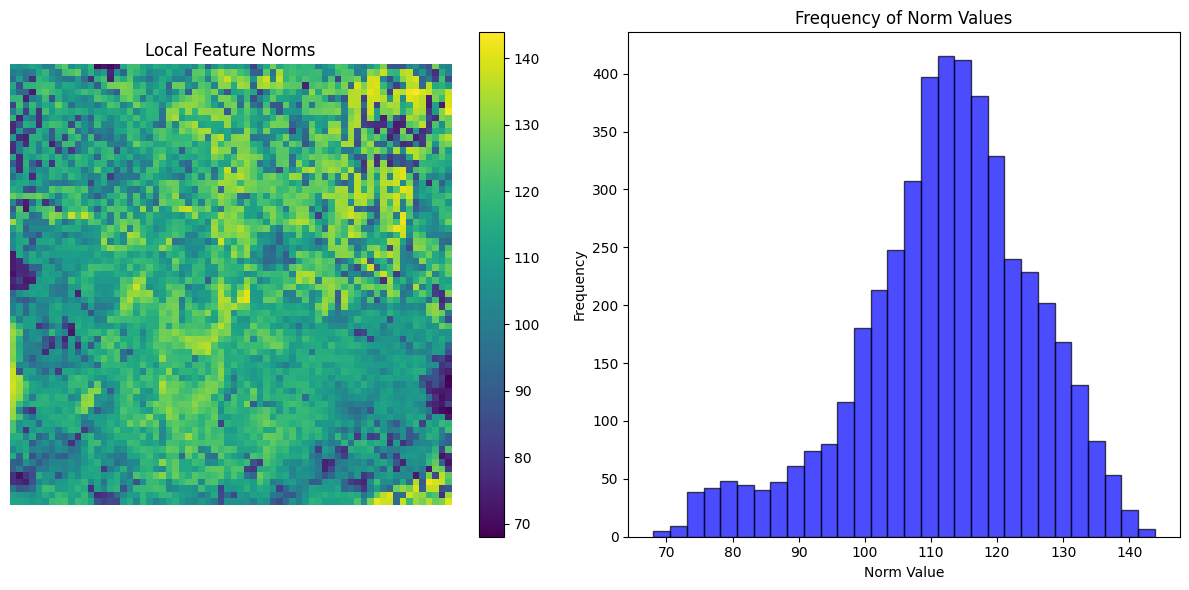

In [5]:
# DINOV2 NORMS WITH REGISTERS

features = model_reg.forward_features(img)["x_prenorm"]
patch_features = features[:, 1 + 4:, :]
local_feature_norms = torch.norm(patch_features, dim=-1) 
w_featmap = img.shape[-2] // patch_size
h_featmap = img.shape[-1] // patch_size


num_patches = patch_features.shape[1]
local_feature_norms = local_feature_norms.reshape(-1, w_featmap, h_featmap)

flattened_norms = local_feature_norms[0].cpu().numpy().flatten()
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(local_feature_norms[0].cpu().numpy(), cmap="viridis")
plt.colorbar()
plt.title("Local Feature Norms")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.hist(flattened_norms, bins=30, color="blue", alpha=0.7, edgecolor="black")
plt.title("Frequency of Norm Values")
plt.xlabel("Norm Value")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()